# 1. Download data from Google Play Store and set up data frame

In [1]:
#from google_play_scraper import app, Sort, reviews_all, reviews

In [5]:
#result, continuation_token = reviews(
#     'de.rki.coronawarnapp',
#     lang = 'de', # defaults to 'en'
#     country = 'de', # defaults to 'us'
#     sort = Sort.NEWEST, # defaults to Sort.MOST_RELEVANT,
#     count = 20000
# )

## Convert to Pandas Dataframe

In [11]:
#df = pd.DataFrame(result)
#df

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,gp:AOqpTOGj3o9mKE0wcJI7gUvMWA96hnt6THeujGrhrZL...,Thomas Wolf,https://lh3.googleusercontent.com/a-/AOh14GgH1...,Läuft nicht rund. Ich schmeiß sie wieder runte...,3,0,1.3.0,2020-09-10 17:53:33,None,NaT
1,gp:AOqpTOHLTv_VitS-R8Oh-zQAVsYapk5hPsM2xd3ej_p...,Sylvia,https://play-lh.googleusercontent.com/-E7i_LQp...,Edit 10.09. Nach dem Neustart ging es erst. Nu...,5,19,1.3.0,2020-09-10 17:16:07,EDIT6: Danke für Ihr erneutes Feedback und Ihr...,2020-09-10 09:47:38
2,gp:AOqpTOEyYwP8GeSIo3q3kdiE8tAXxwV5LBT8wiFshA4...,Daniela Schreiber,https://play-lh.googleusercontent.com/-YQzgA7h...,Habe nun schon 2 mal meine Tests registriert u...,1,1,None,2020-09-10 17:07:06,None,NaT
3,gp:AOqpTOGJzZnDKL1q8o00b-UTi7hHNQEcw6cCXYlhDpd...,Anonym Anonym,https://play-lh.googleusercontent.com/-rCxeV2p...,Hat keine Benachrichtigung gesendet obwohl Kon...,1,0,1.3.0,2020-09-10 17:03:40,Wenn bei Ihnen die Risikoermittlung >24h nicht...,2020-09-10 10:44:15
4,gp:AOqpTOErFUqPpCQRVrgIAYz-SyD09Bl18Fd_VwX4Ytt...,Philipp Weingärtner,https://play-lh.googleusercontent.com/-5J5WloW...,Gemeinsam gegen den coronavirus ist das gut.we...,5,0,1.3.0,2020-09-10 17:02:15,None,NaT
...,...,...,...,...,...,...,...,...,...,...
19995,gp:AOqpTOEYDicO2sEJdOabBU8V7VAiqBxb_DNLxIkVu4t...,Yv,https://lh3.googleusercontent.com/-UyFf2TIWp8s...,"Samsung A8, eigentlich wichtige App, leider fu...",2,5,1.0.2,2020-06-20 16:16:27,Danke für die Rückmeldung. Dieser Fehler kann ...,2020-06-20 17:11:34
19996,gp:AOqpTOGl8LIk5bvQ-8Nmin7asYOxoKOheVJ7ArjCwtk...,Barbara Drischel,https://lh3.googleusercontent.com/a-/AOh14GgMo...,Die App läuft einwandfrei. Aber das Virus kann...,5,0,1.0.2,2020-06-20 16:16:07,None,NaT
19997,gp:AOqpTOHpOi0KJfxUI3D8CR7jjn7QVbsn52zMVymfFYO...,Yogurt Styles,https://lh3.googleusercontent.com/-X4LXIqUznN8...,"Unzufrieden damit, dass ich meinen Standort je...",1,4,None,2020-06-20 16:15:14,Danke für Ihr Feedback. Die Corona-Warn-App gr...,2020-06-23 22:54:52
19998,gp:AOqpTOE-ZUrcM7d3XAFqEatvXWKGvjFTWzESN2XOS2s...,Wolfgang Fehse,https://lh3.googleusercontent.com/-32xScOIJa_M...,Zieht viel Strom. Akku extrem schnell leer . D...,2,2,None,2020-06-20 16:12:42,Danke für Ihr Feedback. Die Corona-Warn-App nu...,2020-06-26 13:36:22


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [2]:
#df.to_csv('rki_corona.csv')
df = pd.read_csv('rki_corona.csv', index_col=[0])

# 2. EDA

In [55]:
df.loc[:, df.isnull().any()].columns

Index(['reviewCreatedVersion', 'replyContent', 'repliedAt'], dtype='object')

## 2.1 Version

In [3]:
df_version = df[["score", "reviewCreatedVersion"]].groupby("reviewCreatedVersion").mean()
df_version.reset_index(level=0, inplace=True)

In [4]:
df_version

,reviewCreatedVersion,score
0,1.0.0,2.865854
1,1.0.2,3.320406
2,1.0.4,3.445655
3,1.0.5,2.943271
4,1.1.1,3.097299
5,1.2.0,2.893204
6,1.2.1,2.560752
7,1.3.0,2.654300


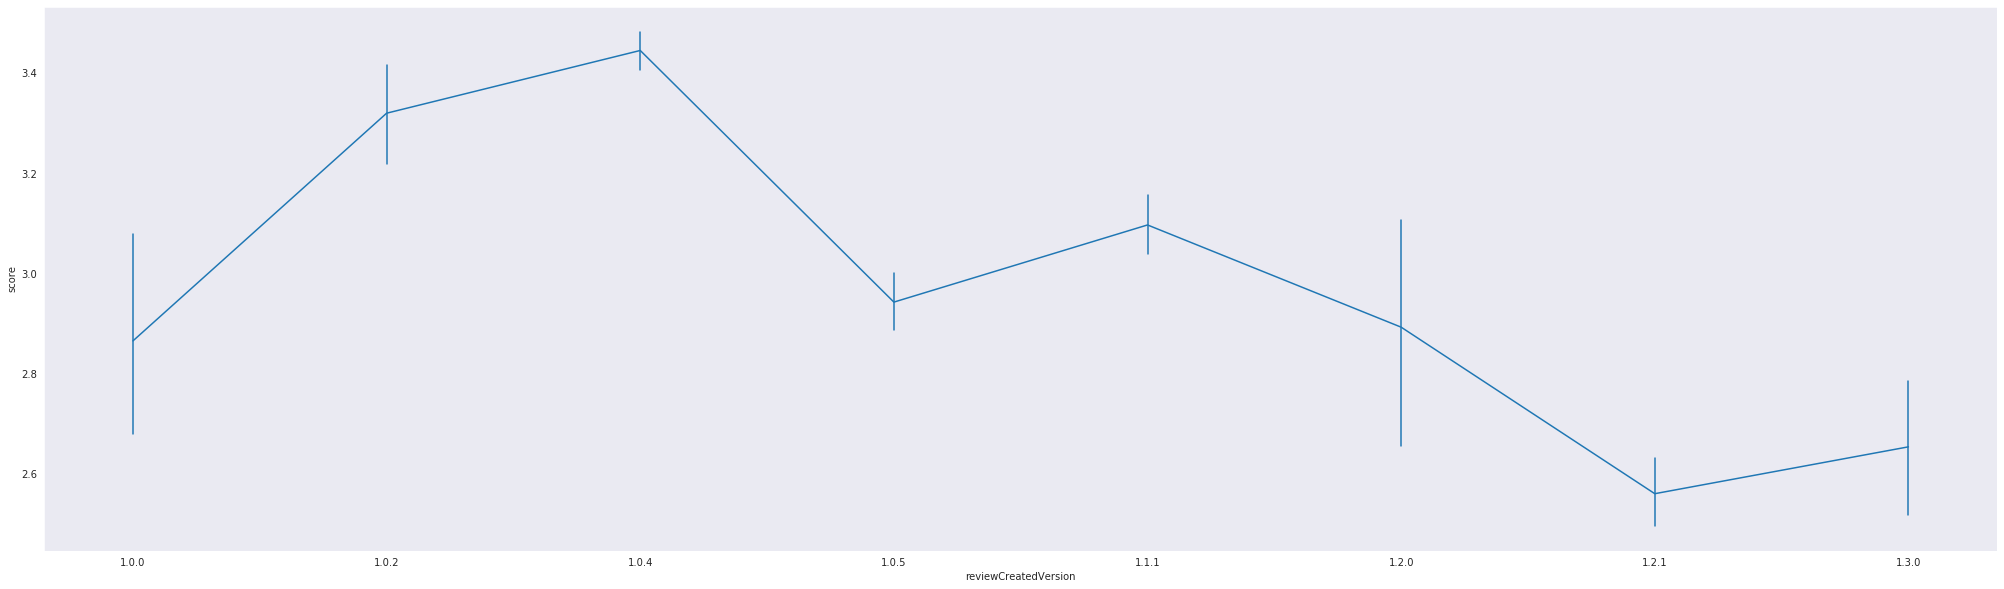

In [5]:
# Only show versions with >= 50 ratings
df_version_filter = df[["score", "reviewCreatedVersion"]].groupby("reviewCreatedVersion").describe()["score"]
df_version_filter.reset_index(level=0, inplace=True)
df_version_filter = df_version_filter[df_version_filter["count"] >= 50]

mask_version = df_version_filter["reviewCreatedVersion"]
df_version_filter = df[df["reviewCreatedVersion"].isin(mask_version)]
plt.figure(figsize=(35,10))
sns.set_style("dark")
sns.lineplot(x = "reviewCreatedVersion", y = "score", err_style = "bars", ci = 95,  palette = "flare", data = df_version_filter)

## 2.2 Scores and Upvotes

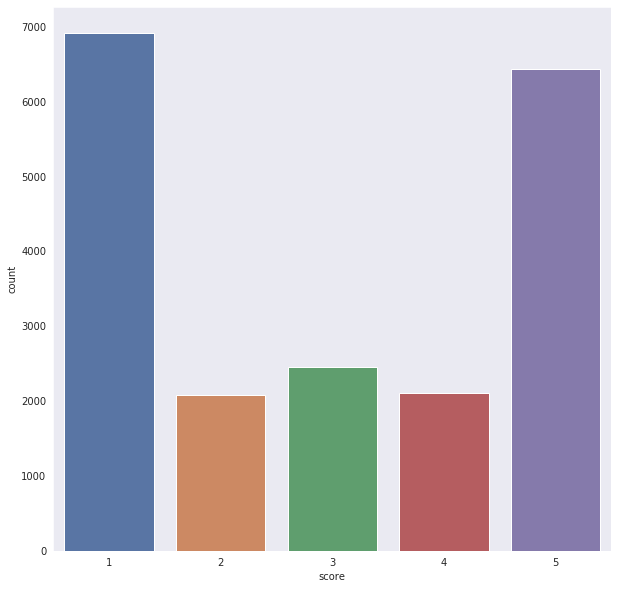

In [6]:
plt.figure(figsize=(10,10))
sns.set_style("dark")
sns.set_palette("deep")
sns.countplot(x = "score", data = df)

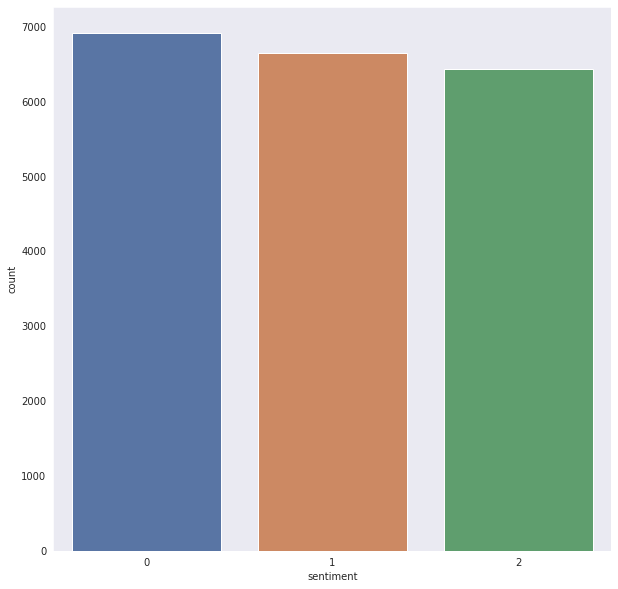

In [7]:
def to_sentiment(rating):
    rating = int(rating)
    if rating == 1:
        return 0
    elif rating >= 2 and rating <= 4:
        return 1
    else:
        return 2

df['sentiment'] = df.score.apply(to_sentiment)

plt.figure(figsize=(10,10))
sns.set_style("dark")
sns.set_palette("deep")
sns.countplot(df.sentiment)

In [8]:
df

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sentiment
0,gp:AOqpTOGj3o9mKE0wcJI7gUvMWA96hnt6THeujGrhrZL...,Thomas Wolf,https://lh3.googleusercontent.com/a-/AOh14GgH1...,Läuft nicht rund. Ich schmeiß sie wieder runte...,3,0,1.3.0,2020-09-10 17:53:33,NaN,NaN,1
1,gp:AOqpTOHLTv_VitS-R8Oh-zQAVsYapk5hPsM2xd3ej_p...,Sylvia,https://play-lh.googleusercontent.com/-E7i_LQp...,Edit 10.09. Nach dem Neustart ging es erst. Nu...,5,19,1.3.0,2020-09-10 17:16:07,EDIT6: Danke für Ihr erneutes Feedback und Ihr...,2020-09-10 09:47:38,2
2,gp:AOqpTOEyYwP8GeSIo3q3kdiE8tAXxwV5LBT8wiFshA4...,Daniela Schreiber,https://play-lh.googleusercontent.com/-YQzgA7h...,Habe nun schon 2 mal meine Tests registriert u...,1,1,NaN,2020-09-10 17:07:06,NaN,NaN,0
3,gp:AOqpTOGJzZnDKL1q8o00b-UTi7hHNQEcw6cCXYlhDpd...,Anonym Anonym,https://play-lh.googleusercontent.com/-rCxeV2p...,Hat keine Benachrichtigung gesendet obwohl Kon...,1,0,1.3.0,2020-09-10 17:03:40,Wenn bei Ihnen die Risikoermittlung >24h nicht...,2020-09-10 10:44:15,0
4,gp:AOqpTOErFUqPpCQRVrgIAYz-SyD09Bl18Fd_VwX4Ytt...,Philipp Weingärtner,https://play-lh.googleusercontent.com/-5J5WloW...,Gemeinsam gegen den coronavirus ist das gut.we...,5,0,1.3.0,2020-09-10 17:02:15,NaN,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...
19995,gp:AOqpTOEYDicO2sEJdOabBU8V7VAiqBxb_DNLxIkVu4t...,Yv,https://lh3.googleusercontent.com/-UyFf2TIWp8s...,"Samsung A8, eigentlich wichtige App, leider fu...",2,5,1.0.2,2020-06-20 16:16:27,Danke für die Rückmeldung. Dieser Fehler kann ...,2020-06-20 17:11:34,1
19996,gp:AOqpTOGl8LIk5bvQ-8Nmin7asYOxoKOheVJ7ArjCwtk...,Barbara Drischel,https://lh3.googleusercontent.com/a-/AOh14GgMo...,Die App läuft einwandfrei. Aber das Virus kann...,5,0,1.0.2,2020-06-20 16:16:07,NaN,NaN,2
19997,gp:AOqpTOHpOi0KJfxUI3D8CR7jjn7QVbsn52zMVymfFYO...,Yogurt Styles,https://lh3.googleusercontent.com/-X4LXIqUznN8...,"Unzufrieden damit, dass ich meinen Standort je...",1,4,NaN,2020-06-20 16:15:14,Danke für Ihr Feedback. Die Corona-Warn-App gr...,2020-06-23 22:54:52,0
19998,gp:AOqpTOE-ZUrcM7d3XAFqEatvXWKGvjFTWzESN2XOS2s...,Wolfgang Fehse,https://lh3.googleusercontent.com/-32xScOIJa_M...,Zieht viel Strom. Akku extrem schnell leer . D...,2,2,NaN,2020-06-20 16:12:42,Danke für Ihr Feedback. Die Corona-Warn-App nu...,2020-06-26 13:36:22,1


In [9]:
df.sort_values(["score","thumbsUpCount"], ascending = False).iloc[0:5,[3,4,5,10]]

,content,score,thumbsUpCount,sentiment
7746,Solide App obwohl offenbar noch ein paar Bugs ...,5,771,2
17947,Die App tut das was sie verspricht. Anfangs ha...,5,474,2
17786,Super App! Jeder der schon einmal eine App ent...,5,356,2
9662,Gute einfach zu nutzende App. Datenschutz sehr...,5,349,2
18380,"Die App tut bei mir das was es soll, ist klar ...",5,344,2


In [10]:
df.sort_values(["score"], ascending = True).iloc[0:5,[3,4,5,10]].sort_values(["thumbsUpCount"], ascending = False)

,content,score,thumbsUpCount,sentiment
5120,Nach dem Update auf Version 1.1.1 und installi...,1,12,0
5118,Und schon wieder etwas ist schief gelaufen. Ur...,1,2,0
11872,"Ich habe das gleiche Problem, wie zig andere N...",1,1,0
10734,Direkt Fehler aber jetzt mal Butter bei die Fi...,1,0,0
10740,Hallo mit meinen Tablett in Wi-Fi geht die App...,1,0,0


In [11]:
def to_review_length(review):
    review = len(review)
    return review

df["ReviewLength"] = df.content.apply(to_review_length)

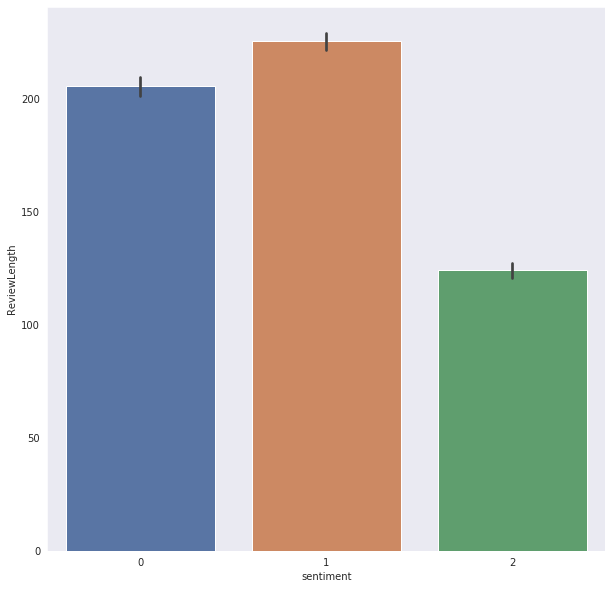

In [12]:
plt.figure(figsize=(10,10))
sns.set_style("dark")
sns.set_palette("deep")
sns.barplot(y = "ReviewLength", x = "sentiment", data = df)

## 2.3 Lemmatization

In [14]:
import treetaggerwrapper
tagger = treetaggerwrapper.TreeTagger(TAGLANG = 'de', TAGDIR = '/home/sebastian/Programme/TreeTagger/')

In [15]:
# tagger example #1
tag_ex = tagger.tag_text("Täglich grüßt das Murmeltier.", tagonly = False)

tags2 = treetaggerwrapper.make_tags(tag_ex)
tags2
tag_list = list(list(zip(*tags2))[2])
tag_list

['täglich', 'grüßen', 'die', 'Murmeltier', '.']

In [95]:
def preprocess_text(text_column):

    # replace dot to fully identify tokens
    text_long = str(text_column).replace(".", " ")
    # set dummy text for problematic rows
    if text_long == "   ":
        text_long = "Pythagoras"

    # tag sentence
    tags = tagger.tag_text(text_long, tagonly = False)
    tags2 = treetaggerwrapper.make_tags(tags)

    tag_tuple_list = []
    for element in tags2:
        if len(element) == 3:
            tag_tuple_list.append(element)
        else:
            next

    tag_list = list(list(zip(*tag_tuple_list))[2])
    
    # store in on long text variable
    text_long = ""
    for val in tag_list:
        text_long = text_long + str(val) + ' '

    # lower all characters
    tokens = text_long.split()
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower()

    # store in on long text variable
    text_long = ""
    for words in tokens: 
        text_long = text_long + words + ' '
    
    return text_long

In [96]:
# tagger exmaple #2
df_test = df.copy()
df_test.reset_index(inplace = True)
df_test = df_test.loc[5500:5520]
df_test["LemmaReview"] = df_test.content.apply(preprocess_text)
df_test.LemmaReview

5500                                          sehr gut ! 
5501                                           nicht gut 
5502                                            sehr gut 
5503    nach anfänglich schwierigkeit bei die risikoer...
5504                                  laufen einwandfrei 
5505    eine sehr sehr gut app ! 👍👍nur sie braut zieml...
5506    keine problem mit dies app täglich aktualisier...
5507    haben handy mit prepaid karte klappen es auch ...
5508    big brother sein watching you all nur lug und ...
5509                        alle super ! unverzichtbar ! 
5510                                       sein schlecht 
5511    fehler @card@ und @card@ sein beseitigt jetzt ...
5512    bei ich sein es “ fehler bei kommunikation mit...
5513                                      wieder löschen 
5514                                  laufen einwandfrei 
5515    app sein wohl in die aktuell version drauf , a...
5516                            gehen auf mein p30 prima 
5517          

In [97]:
df["LemmaReview"] = df.content.apply(preprocess_text)

## 2.4 Wordcloud

In [108]:
def to_long_string(text_column):
    # store in one long text variable
    text_long = ""
    for word in text_column:
        text_long = text_long + str(word) + ' '
    return text_long

In [112]:
review_bad = to_long_string(df[df["sentiment"] == 0].LemmaReview)
review_neutral = to_long_string(df[df["sentiment"] == 1].LemmaReview)
review_good = to_long_string(df[df["sentiment"] == 2].LemmaReview)

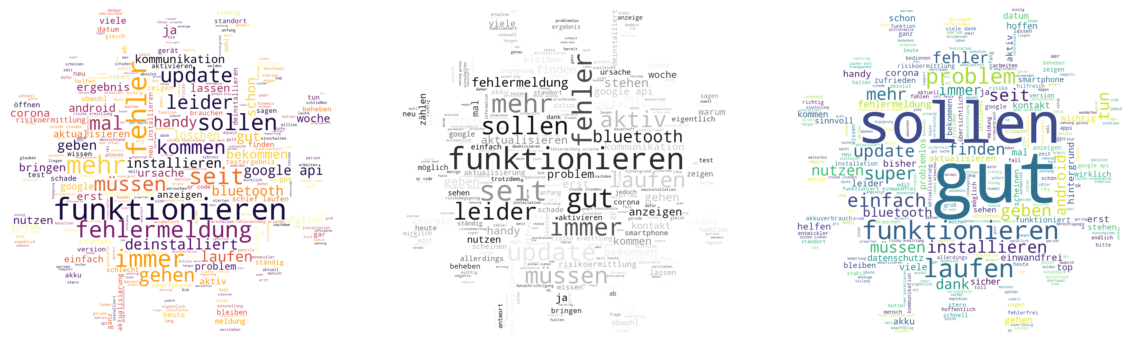

In [116]:
## generate word cloud
from wordcloud import WordCloud
from nltk.corpus import stopwords
import numpy as np
from PIL import Image

# add mask
play_mask = np.array(Image.open("virus.png"))

# add stop words
german_stop_words = stopwords.words('german')
stoplist = list(set(german_stop_words))
stop_words = ["card", "tag", "card ", "app"] + stoplist

# specify colors
def bad_color_func(word, font_size, position, orientation, random_state,
        **kwargs):
    return "hsl(8, 0%%, %d%%)" % random.randint(60, 100)

# specifiy clouds
wordcloud_bad = WordCloud(
            mask = play_mask,
            width = 1000,
            height = 1000,
            background_color ='white',
            colormap = matplotlib.cm.inferno,
            stopwords = stop_words,
            max_words = 300,
            min_font_size = 5).generate(review_bad)

wordcloud_neutral = WordCloud(
            mask = play_mask,
            width = 1000,
            height = 1000,
            background_color ='white',
            colormap = matplotlib.cm.Greys,
            stopwords = stop_words,
            max_words = 300,
            min_font_size = 5).generate(review_neutral)

wordcloud_good = WordCloud(
            mask = play_mask,
            width = 1000,
            height = 1000,
            background_color ='white', 
            stopwords = stop_words,
            max_words = 300,
            min_font_size = 5).generate(review_good)

# plot the WordCloud image
f = plt.figure(figsize=(20,15))

f.add_subplot(1,3, 1)
plt.imshow(wordcloud_bad, interpolation = 'bilinear')
plt.axis("off")

f.add_subplot(1,3, 2)
plt.imshow(wordcloud_neutral, interpolation = 'bilinear')
plt.axis("off")

f.add_subplot(1,3, 3)
plt.imshow(wordcloud_good, interpolation = 'bilinear')
plt.axis("off")

plt.show()

### 2.4.1 Weight sentences based upon thumbs

In [117]:
df_weight = df.copy()
df_weight["thumbsUpCount"] = df_weight["thumbsUpCount"] + 1
df_weight.reindex(df_weight.index.repeat(df_weight.thumbsUpCount))
df_weight = df_weight.reindex(df_weight.index.repeat(df_weight.thumbsUpCount))
df_weight = df_weight.loc[:, ~df_weight.columns.str.match('Unnamed')]
df_weight

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sentiment,ReviewLength,LemmaReview
0,gp:AOqpTOGj3o9mKE0wcJI7gUvMWA96hnt6THeujGrhrZL...,Thomas Wolf,https://lh3.googleusercontent.com/a-/AOh14GgH1...,Läuft nicht rund. Ich schmeiß sie wieder runte...,3,1,1.3.0,2020-09-10 17:53:33,NaN,NaN,1,57,laufen nicht rund ich schmeißen sie wieder run...
1,gp:AOqpTOHLTv_VitS-R8Oh-zQAVsYapk5hPsM2xd3ej_p...,Sylvia,https://play-lh.googleusercontent.com/-E7i_LQp...,Edit 10.09. Nach dem Neustart ging es erst. Nu...,5,20,1.3.0,2020-09-10 17:16:07,EDIT6: Danke für Ihr erneutes Feedback und Ihr...,2020-09-10 09:47:38,2,370,edit @card@ @card@ nach die neustart gehen es ...
1,gp:AOqpTOHLTv_VitS-R8Oh-zQAVsYapk5hPsM2xd3ej_p...,Sylvia,https://play-lh.googleusercontent.com/-E7i_LQp...,Edit 10.09. Nach dem Neustart ging es erst. Nu...,5,20,1.3.0,2020-09-10 17:16:07,EDIT6: Danke für Ihr erneutes Feedback und Ihr...,2020-09-10 09:47:38,2,370,edit @card@ @card@ nach die neustart gehen es ...
1,gp:AOqpTOHLTv_VitS-R8Oh-zQAVsYapk5hPsM2xd3ej_p...,Sylvia,https://play-lh.googleusercontent.com/-E7i_LQp...,Edit 10.09. Nach dem Neustart ging es erst. Nu...,5,20,1.3.0,2020-09-10 17:16:07,EDIT6: Danke für Ihr erneutes Feedback und Ihr...,2020-09-10 09:47:38,2,370,edit @card@ @card@ nach die neustart gehen es ...
1,gp:AOqpTOHLTv_VitS-R8Oh-zQAVsYapk5hPsM2xd3ej_p...,Sylvia,https://play-lh.googleusercontent.com/-E7i_LQp...,Edit 10.09. Nach dem Neustart ging es erst. Nu...,5,20,1.3.0,2020-09-10 17:16:07,EDIT6: Danke für Ihr erneutes Feedback und Ihr...,2020-09-10 09:47:38,2,370,edit @card@ @card@ nach die neustart gehen es ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19997,gp:AOqpTOHpOi0KJfxUI3D8CR7jjn7QVbsn52zMVymfFYO...,Yogurt Styles,https://lh3.googleusercontent.com/-X4LXIqUznN8...,"Unzufrieden damit, dass ich meinen Standort je...",1,5,NaN,2020-06-20 16:15:14,Danke für Ihr Feedback. Die Corona-Warn-App gr...,2020-06-23 22:54:52,0,212,"unzufrieden damit , dass ich mein standort jed..."
19998,gp:AOqpTOE-ZUrcM7d3XAFqEatvXWKGvjFTWzESN2XOS2s...,Wolfgang Fehse,https://lh3.googleusercontent.com/-32xScOIJa_M...,Zieht viel Strom. Akku extrem schnell leer . D...,2,3,NaN,2020-06-20 16:12:42,Danke für Ihr Feedback. Die Corona-Warn-App nu...,2020-06-26 13:36:22,1,95,zeihen|ziehen viele strom akku extrem schnell ...
19998,gp:AOqpTOE-ZUrcM7d3XAFqEatvXWKGvjFTWzESN2XOS2s...,Wolfgang Fehse,https://lh3.googleusercontent.com/-32xScOIJa_M...,Zieht viel Strom. Akku extrem schnell leer . D...,2,3,NaN,2020-06-20 16:12:42,Danke für Ihr Feedback. Die Corona-Warn-App nu...,2020-06-26 13:36:22,1,95,zeihen|ziehen viele strom akku extrem schnell ...
19998,gp:AOqpTOE-ZUrcM7d3XAFqEatvXWKGvjFTWzESN2XOS2s...,Wolfgang Fehse,https://lh3.googleusercontent.com/-32xScOIJa_M...,Zieht viel Strom. Akku extrem schnell leer . D...,2,3,NaN,2020-06-20 16:12:42,Danke für Ihr Feedback. Die Corona-Warn-App nu...,2020-06-26 13:36:22,1,95,zeihen|ziehen viele strom akku extrem schnell ...


In [121]:
review_bad_weight = to_long_string(df_weight[df_weight["sentiment"] == 0].LemmaReview)
review_neutral_weight = to_long_string(df_weight[df_weight["sentiment"] == 1].LemmaReview)
review_good_weight = to_long_string(df_weight[df_weight["sentiment"] == 2].LemmaReview)

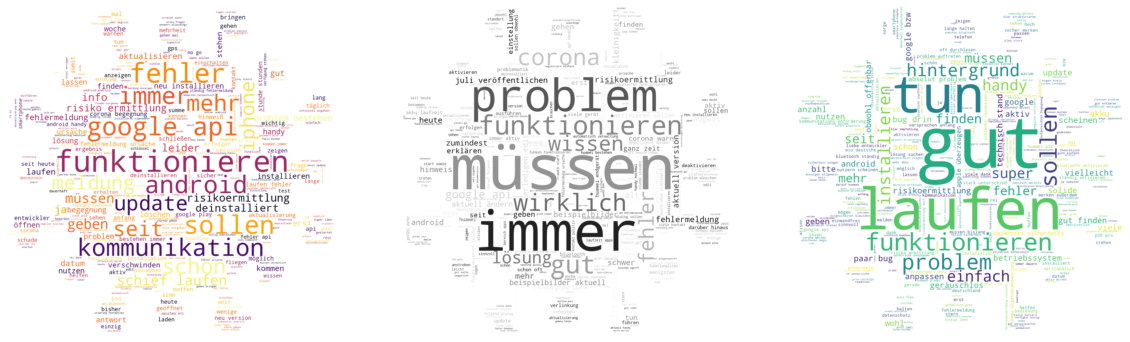

In [123]:
## generate word cloud
# add mask
play_mask = np.array(Image.open("virus.png"))

# add stop words
german_stop_words = stopwords.words('german')
stoplist = list(set(german_stop_words))
stop_words = ["card", "tag", "card ", "app"] + stoplist

# specify colors
def bad_color_func(word, font_size, position, orientation, random_state,
        **kwargs):
    return "hsl(8, 0%%, %d%%)" % random.randint(60, 100)

# specifiy clouds
wordcloud_bad = WordCloud(
            mask = play_mask,
            width = 1000,
            height = 1000,
            background_color ='white',
            colormap = matplotlib.cm.inferno,
            stopwords = stop_words,
            max_words = 300,
            min_font_size = 5).generate(review_bad_weight)

wordcloud_neutral = WordCloud(
            mask = play_mask,
            width = 1000,
            height = 1000,
            background_color ='white',
            colormap = matplotlib.cm.Greys,
            stopwords = stop_words,
            max_words = 300,
            min_font_size = 5).generate(review_neutral_weight)

wordcloud_good = WordCloud(
            mask = play_mask,
            width = 1000,
            height = 1000,
            background_color ='white', 
            stopwords = stop_words,
            max_words = 300,
            min_font_size = 5).generate(review_good_weight)

# plot the WordCloud image
f = plt.figure(figsize=(20,15))

f.add_subplot(1,3, 1)
plt.imshow(wordcloud_bad, interpolation = 'bilinear')
plt.axis("off")

f.add_subplot(1,3, 2)
plt.imshow(wordcloud_neutral, interpolation = 'bilinear')
plt.axis("off")

f.add_subplot(1,3, 3)
plt.imshow(wordcloud_good, interpolation = 'bilinear')
plt.axis("off")

plt.show()

### 2.4.2 unique words

In [124]:
set_bad = set(review_bad_weight.split()) - set(review_good_weight.split()) - set(review_neutral_weight.split())
set_neutral = set(review_neutral_weight.split()) - set(review_good_weight.split()) - set(review_bad_weight.split())
set_good = set(review_good_weight.split()) - set(review_bad_weight.split()) - set(review_neutral_weight.split())

def matching(list_of_text, diff_set):
    text_long = ""
    for i in list_of_text:
        if i in diff_set:
            text_long = text_long + str(i) + " "
    return text_long

In [125]:
review_bad_unique = matching(review_bad_weight.split(), set_bad)
review_neutral_unique = matching(review_neutral_weight.split(), set_neutral)
review_good_unique = matching(review_good_weight.split(), set_good)

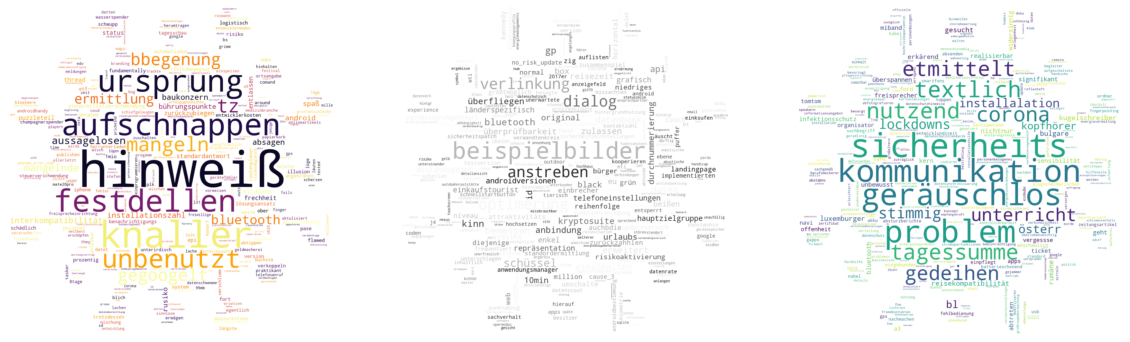

In [128]:
## generate word cloud
# add mask
play_mask = np.array(Image.open("virus.png"))

# add stop words
german_stop_words = stopwords.words('german')
stoplist = list(set(german_stop_words))
stop_words = ["card", "tag", "card ", "app"] + stoplist

# specify colors
def bad_color_func(word, font_size, position, orientation, random_state,
        **kwargs):
    return "hsl(8, 0%%, %d%%)" % random.randint(60, 100)

# specifiy clouds
wordcloud_bad = WordCloud(
            mask = play_mask,
            width = 1000,
            height = 1000,
            background_color ='white',
            colormap = matplotlib.cm.inferno,
            collocations = False,
            stopwords = stop_words,
            max_words = 300,
            min_font_size = 5).generate(review_bad_unique)

wordcloud_neutral = WordCloud(
            mask = play_mask,
            width = 1000,
            height = 1000,
            background_color ='white',
            colormap = matplotlib.cm.Greys,
            collocations = False,
            stopwords = stop_words,
            max_words = 300,
            min_font_size = 5).generate(review_neutral_unique)

wordcloud_good = WordCloud(
            mask = play_mask,
            width = 1000,
            height = 1000,
            background_color ='white',
            collocations = False,
            stopwords = stop_words,
            max_words = 300,
            min_font_size = 5).generate(review_good_unique)

# plot the WordCloud image
f = plt.figure(figsize=(20,15))

f.add_subplot(1,3, 1)
plt.imshow(wordcloud_bad, interpolation = 'bilinear')
plt.axis("off")

f.add_subplot(1,3, 2)
plt.imshow(wordcloud_neutral, interpolation = 'bilinear')
plt.axis("off")

f.add_subplot(1,3, 3)
plt.imshow(wordcloud_good, interpolation = 'bilinear')
plt.axis("off")

plt.show()